### Load libraries

In [1]:
# Basic libraries
import os, sys
from datetime import date
import pandas as pd 
import numpy as np 
import scanpy as sc 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# DGE analysis
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import decoupler 

# GO analysis
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import gseapy as gp
from gseapy.plot import gseaplot

<i><b> Set the home directory </b></i>

In [2]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

<i><b> Set the container image </b></i>

In [3]:
with open("/image_version", "r") as f:
    image_name = f.readline().replace("\n", "")
image_name

'sddcunit/downstream:sc-1.1.0'

### Load the data

In [4]:
# Load the data
adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_clustered.h5ad")
adata.shape

(113667, 10801)

In [5]:
# Ensure that categories are strings
adata.obs['leiden_subclustered_G1_RG_ss']  = adata.obs['leiden_subclustered_G1_RG_ss'].astype(str)
adata.obs['X_leiden_harmony']  = adata.obs['X_leiden_harmony'].astype(str)

# Map original clusters to the new cluster category 
adata.obs['leiden_subclustered_G1_RG_ss'] = adata.obs['leiden_subclustered_G1_RG_ss'].mask(adata.obs['leiden_subclustered_G1_RG_ss'] == "", adata.obs['X_leiden_harmony'])
adata.shape

(113667, 10801)

### Expression markers

In [6]:
# Subset to RG clusters
adata_ss = adata[adata.obs['leiden_subclustered_G1_RG_ss'].isin(['human_ncx_RG 2', 'human_ncx_RG 1', 'human_ncx_RG 3', 
                                                                 'mouse_dg_RG 1', 'mouse_dg_RG 2', 'mouse_ncx_G1 RG,0'])].copy()

/tmp/ipykernel_1777938/1137028683.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


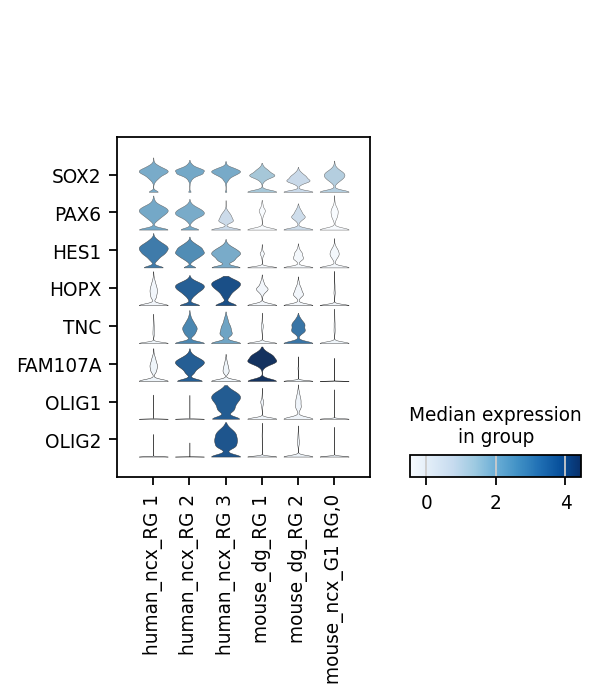

In [7]:
# Convert to categories
adata_ss.obs['leiden_subclustered_G1_RG_ss'] = adata_ss.obs['leiden_subclustered_G1_RG_ss'].astype('category')

# Plot the broad range of marker genes
sc.set_figure_params(fontsize=10)

# Define markers 
markers = ['SOX2', 'PAX6', 'HES1', 'HOPX', 'TNC', 'FAM107A', 'OLIG1', 'OLIG2']
ax = sc.pl.stacked_violin(adata_ss, markers, groupby='leiden_subclustered_G1_RG_ss', dendrogram=False, swap_axes = True, show = False, yticklabels = None)

plt.tight_layout()
plt.savefig("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/Violin_plots_RG_markers.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

In [8]:
del adata_ss

### Pseudobulking

In [9]:
# Remove clusters of non-neuronal lineages
adata_neuronal = adata[~adata.obs['leiden_subclustered_G1_RG_ss'].isin(['Microglia', 'Endothelial', 'IN1', 'IN2', 'Glia'])].copy()
adata_neuronal.shape

(94677, 10801)

In [10]:
# Group neuronal clusters together
adata_neuronal.obs["leiden_subclustered_G1_RG_ss"] = adata.obs["leiden_subclustered_G1_RG_ss"].astype('category')

cluster_combination = {'N1':'N', 
                       'N2':'N',
                       'N3':'N',
                       'N4':'N', 
                       'N5': 'N',
                       'N6':'N', 
                       'N7':'N', 
                       'G1 IPs': 'G1 IPs', 
                       'G2M-S Pgs':'G2M-S Pgs', 
                       'human_ncx_RG 2':'human_ncx_RG_2', 
                       'human_ncx_RG 1': 'human_ncx_RG_1', 
                       'human_ncx_RG 3': 'human_ncx_RG_3', 
                       'mouse_dg_RG 1': 'mouse_dg_RG_1', 
                       'mouse_dg_RG 2': 'mouse_dg_RG_2', 
                       'mouse_ncx_G1 RG,0': 'mouse_ncx_RG'}

default_name = "unknown"

adata_neuronal.obs["leiden_subclustered_G1_RG_ss_merged"] = adata_neuronal.obs["leiden_subclustered_G1_RG_ss"].map(cluster_combination).fillna(default_name)
adata_neuronal.obs["leiden_subclustered_G1_RG_ss_merged"] = adata_neuronal.obs["leiden_subclustered_G1_RG_ss_merged"].astype('category') 

In [11]:
# Switch to raw counts
adata_neuronal.X = adata_neuronal.layers['counts'].copy()
# Round the numbers 
adata_neuronal.X = np.round(adata_neuronal.X)

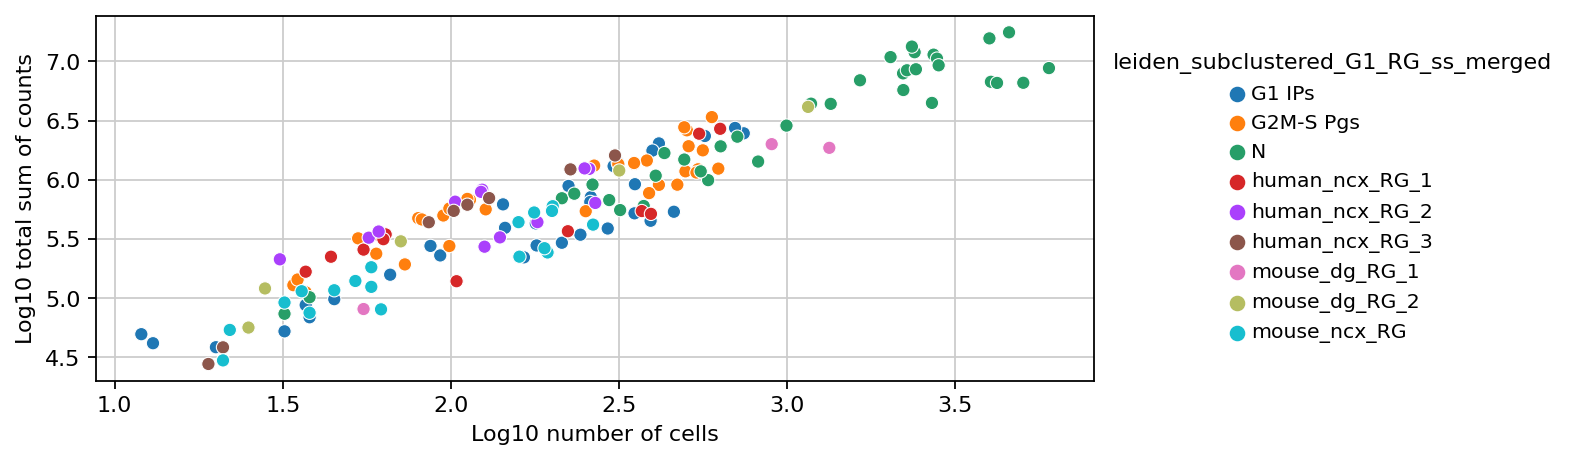

In [12]:
# Generate pseudobulk counts
pdata = decoupler.get_pseudobulk(
    adata_neuronal,
    sample_col='sample_id',
    groups_col='leiden_subclustered_G1_RG_ss_merged',
    layer='counts',
    mode= 'sum',
    min_cells=10,
    min_counts=10000
)

# Plot
decoupler.plot_psbulk_samples(pdata, groupby='leiden_subclustered_G1_RG_ss_merged', figsize=(8, 3), dpi = 80)

### DGE analysis 

In [13]:
# Subset to clusters of interest
brg_hs_ncx_mm_dg = pdata[pdata.obs['leiden_subclustered_G1_RG_ss_merged'].isin(['human_ncx_RG_2', 'mouse_dg_RG_1'])].copy()

In [14]:
# Prepare the DeSeq2 format
dds = DeseqDataSet(
    adata = brg_hs_ncx_mm_dg,    
    design_factors= ['leiden_subclustered_G1_RG_ss_merged'],
    ref_level=['leiden_subclustered_G1_RG_ss_merged', 'human_ncx_RG_2'],
    refit_cooks=True)

/tmp/ipykernel_1777938/3910226741.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
/usr/local/lib/python3.10/dist-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [15]:
# Perform deseq2
dds.deseq2() 

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 16.16 seconds.

Fitting dispersion trend curve...
... done in 2.07 seconds.

Fitting MAP dispersions...
... done in 15.41 seconds.

Fitting LFCs...
... done in 2.12 seconds.

Refitting 18 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [16]:
# Output results
stat_res = DeseqStats(dds, contrast=['leiden-subclustered-G1-RG-ss-merged', 'human-ncx-RG-2', 'mouse-dg-RG-1'])
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: leiden-subclustered-G1-RG-ss-merged human-ncx-RG-2 vs mouse-dg-RG-1


... done in 0.90 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,3.382945,-4.121420,0.877864,-4.694827,2.668326e-06,1.096087e-05
AAAS,17.157108,2.056450,0.399540,5.147044,2.646239e-07,1.288712e-06
AACS,13.686907,-0.984549,0.478626,-2.057030,3.968330e-02,6.644889e-02
AADAT,7.427963,4.064311,0.851770,4.771604,1.827644e-06,7.695080e-06
AAGAB,7.232475,-1.080718,0.306551,-3.525407,4.228328e-04,1.125546e-03
...,...,...,...,...,...,...
ZXDC,12.242067,0.185691,0.394968,0.470142,6.382539e-01,7.096315e-01
ZYG11B,42.354404,0.081080,0.182309,0.444742,6.565064e-01,7.252903e-01
ZYX,23.554743,1.157583,0.294348,3.932696,8.399836e-05,2.591050e-04
ZZEF1,13.352003,-1.731474,0.312645,-5.538153,3.056775e-08,1.719157e-07


In [17]:
# Output the dataframe
results_df = stat_res.results_df
# Reindex the dataframe
results_df_bRG = results_df.copy()
results_df_bRG.reset_index(inplace=True)
results_df_bRG.rename(columns ={'index':'gene_name'}, inplace = True)

In [18]:
# Convert to -log10padj
results_df['log_10_padj'] = -np.log10(results_df['padj'])
# Cap the -log10padj
cap = 10
results_df['log_10_padj_capped'] = np.where(results_df['log_10_padj']>cap, cap, results_df['log_10_padj'])

In [19]:
# Filter the p adjusted 
DEGs_bRG = results_df[results_df['padj'] < 0.05]
# Filtr the log2FC
degs_human_up = DEGs_bRG[DEGs_bRG['log2FoldChange'] > 1]
degs_human_down = DEGs_bRG[DEGs_bRG['log2FoldChange'] < -1]
# Print the number of up and down-regulated genes
print(len(degs_human_up))
print(len(degs_human_down))

2853
2331


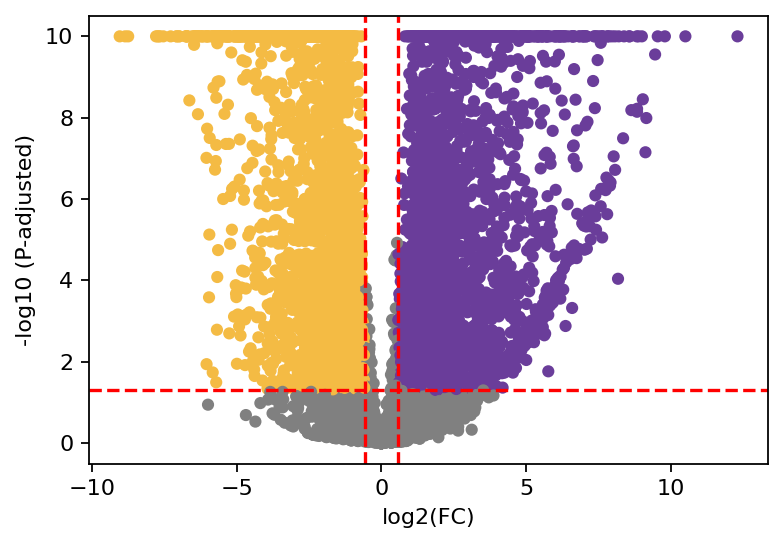

In [20]:
%run -i '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scmorpho_final/helper_functions/Volcano_plot.py'
# Plot the volcano plot
volcano_plot(df = results_df, df_up=degs_human_up, df_down=degs_human_down)
plt.grid(False)
plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/degs/hs_ncx_rg2_vs_mm_dg_rg_1/Volcano_plot_hs_ncx_rg2_vs_mm_dg_rg_1.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [21]:
degs_human_up_sorted = degs_human_up.sort_values(by='log2FoldChange', ascending=False)
degs_human_up_sorted.head(5)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log_10_padj,log_10_padj_capped
CST3,677.745239,12.315785,1.483465,8.302041,1.023381e-16,1.588376e-15,14.799047,10.000000
MOXD1,194.847519,10.514232,1.440490,7.299067,2.897706e-13,3.104028e-12,11.508074,10.000000
DYNLL1,400.019531,9.804882,0.824868,11.886604,1.389415e-32,7.846920e-31,30.105301,10.000000
LRRC3B,253.887146,9.558325,0.951078,10.049991,9.187601e-24,2.628824e-22,21.580239,10.000000
DDX3X,94.195992,9.466887,1.427787,6.630464,3.346331e-11,2.789558e-10,9.554465,9.554465


### Save DGE results

In [22]:
# Save the background genes 
results_df.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/hs_ncx_rg2_vs_mm_dg_rg_1/background_genes_hs_ncx_rg2_vs_mm_dg_rg_1.csv')
results_df.shape

(10801, 8)

In [23]:
 # Save the up-regulated genes
degs_human_up.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/hs_ncx_rg2_vs_mm_dg_rg_1/DEGs_up_hs_ncx_rg2_vs_mm_dg_rg_1.csv')
print(len(degs_human_up))
# Save the down-regulated genes
degs_human_down.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/hs_ncx_rg2_vs_mm_dg_rg_1/DEGs_down_hs_ncx_rg2_vs_mm_dg_rg_1.csv')
print(len(degs_human_down))

2853
2331


### GO analysis

In [24]:
# Convert background genes to a list
background_list = results_df.index.tolist()
# Convert up-regulated genes to a list
degs_human_up_list = degs_human_up.index.tolist()
# Convert down-regulated genes to a list
degs_human_down_list = degs_human_down.index.tolist()

In [25]:
# Load the ontology lists
ontology_list = ['/group/kalebic/Nikola/1_single_cell_final/Chiara_final/scadd1ko/.cache/msigdb/c5.go.bp.v2023.2.Hs.symbols.gmt', 
                 #'/group/kalebic/Nikola/1_single_cell_final/Chiara_final/scadd1ko/.cache/msigdb/c5.go.cc.v2023.2.Hs.symbols.gmt', 
                 #'/group/kalebic/Nikola/1_single_cell_final/Chiara_final/scadd1ko/.cache/msigdb/c5.go.mf.v2023.2.Hs.symbols.gmt',
                 #'/group/kalebic/Nikola/1_single_cell_final/Chiara_final/scadd1ko/.cache/msigdb/c2.cp.v2023.2.Hs.symbols.gmt'
                 ]

In [26]:
# Perform GO analysis
# Up-regulated in human Ncx bRG 1 vs mouse DG bRG 1
FAM107A_RG_hsNcx_vs_mmDG_up = gp.enrichr(gene_list= degs_human_up_list, 
                                  gene_sets= ontology_list, 
                                  organism='Human', 
                                  cutoff=0.5, 
                                  background = background_list,
                                  no_plot= True)

FAM107A_RG_hsNcx_vs_mmDG_up_df = pd.DataFrame(FAM107A_RG_hsNcx_vs_mmDG_up.results)

# Down-regulated in human Ncx bRG 1 vs mouse DG bRG 1
FAM107A_RG_hsNcx_vs_mmDG_down = gp.enrichr(gene_list= degs_human_down_list, 
                                    gene_sets= ontology_list, 
                                    organism='Human', 
                                    cutoff=0.5, 
                                    background = background_list,
                                    no_plot= True)

FAM107A_RG_hsNcx_vs_mmDG_down_df = pd.DataFrame(FAM107A_RG_hsNcx_vs_mmDG_down.results)

In [27]:
 # Save the files
# up-regulated GO terms
FAM107A_RG_hsNcx_vs_mmDG_up_df.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/GO/hs_ncx_rg2_vs_mm_dg_rg_1/GO_hs_ncx_rg2_vs_mm_dg_rg_1_UP_enrichment.csv')
# down-regulated GO terms
FAM107A_RG_hsNcx_vs_mmDG_down_df.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/GO/hs_ncx_rg2_vs_mm_dg_rg_1/GO_hs_ncx_rg2_vs_mm_dg_rg_1_DOWN_enrichment.csv')

In [28]:
# Define the 'Gene ontology type' 
FAM107A_RG_hsNcx_vs_mmDG_up_df['Ontology_type'] = FAM107A_RG_hsNcx_vs_mmDG_up_df.Gene_set.str[:8]
FAM107A_RG_hsNcx_vs_mmDG_down_df['Ontology_type'] = FAM107A_RG_hsNcx_vs_mmDG_down_df.Gene_set.str[:8]

In [29]:
# Add the 'regulation' column
FAM107A_RG_hsNcx_vs_mmDG_up_df['regulation'] = 'up-regulated'
FAM107A_RG_hsNcx_vs_mmDG_down_df['regulation'] = 'down-regulated'

In [30]:
# Remove the insignificant terms
FAM107A_RG_hsNcx_vs_mmDG_up_df_sig = FAM107A_RG_hsNcx_vs_mmDG_up_df[FAM107A_RG_hsNcx_vs_mmDG_up_df['Adjusted P-value'] < 0.05]
FAM107A_RG_hsNcx_vs_mmDG_down_df_sig = FAM107A_RG_hsNcx_vs_mmDG_down_df[FAM107A_RG_hsNcx_vs_mmDG_down_df['Adjusted P-value'] < 0.05]

print('Total number of significantly up-regulated GO terms:', len(FAM107A_RG_hsNcx_vs_mmDG_up_df_sig))
print('Total number of significantly down-regulated GO terms:', len(FAM107A_RG_hsNcx_vs_mmDG_down_df_sig))

Total number of significantly up-regulated GO terms: 101
Total number of significantly down-regulated GO terms: 279


In [31]:
# Sort based on the Combined Score
# up-regulated GO terms
FAM107A_RG_hsNcx_vs_mmDG_up_df_sig = FAM107A_RG_hsNcx_vs_mmDG_up_df_sig.sort_values(by = 'Combined Score', ascending=False)
# down-regulated GO terms
FAM107A_RG_hsNcx_vs_mmDG_down_df_sig = FAM107A_RG_hsNcx_vs_mmDG_down_df_sig.sort_values(by = 'Combined Score', ascending=False)

In [32]:
# Clean the 'Term' column 
# up-regulated GO terms
FAM107A_RG_hsNcx_vs_mmDG_up_df_sig['Term_clean'] = FAM107A_RG_hsNcx_vs_mmDG_up_df_sig.Term.apply(lambda x: x[5:])
FAM107A_RG_hsNcx_vs_mmDG_up_df_sig["Term_clean"] = FAM107A_RG_hsNcx_vs_mmDG_up_df_sig["Term_clean"].str.replace("_", " ").str.capitalize()
# down-regulated GO terms
FAM107A_RG_hsNcx_vs_mmDG_down_df_sig['Term_clean'] = FAM107A_RG_hsNcx_vs_mmDG_down_df_sig.Term.apply(lambda x: x[5:])
FAM107A_RG_hsNcx_vs_mmDG_down_df_sig["Term_clean"] = FAM107A_RG_hsNcx_vs_mmDG_down_df_sig["Term_clean"].str.replace("_", " ").str.capitalize()

In [33]:
 # Subset the list of 'up-regulated' GO terms to terms of interest
# up-regulated terms
terms_of_interest_up = ['Microtubule cytoskeleton organization', 'Microtubule based process', 
                        'Mitotic cell cycle', 'Cell cycle dna replication', 'Mitotic spindle organization', 
                        'Microtubule cytoskeleton organization involved in mitosis', 'Microtubule organizing center organization']

FAM107A_RG_hsNcx_vs_mmDG_up_df_sig_ss = FAM107A_RG_hsNcx_vs_mmDG_up_df_sig[FAM107A_RG_hsNcx_vs_mmDG_up_df_sig['Term_clean'].isin(terms_of_interest_up)]

# down-regulated terms
terms_of_interest_down = ['Lipid metabolic process', 'Vascular transport', 'Lipid biosynthetic process', 'Electron transport chain', 
                          'Glycerolipid biosynthetic process', 'Cholesterol efflux', 'Generation of neurons', 'Cell morphogenesis']

FAM107A_RG_hsNcx_vs_mmDG_down_df_sig_ss = FAM107A_RG_hsNcx_vs_mmDG_down_df_sig[FAM107A_RG_hsNcx_vs_mmDG_down_df_sig['Term_clean'].isin(terms_of_interest_down)]

In [34]:
# Concatenate 
FAM107A_RG_hsNcx_vs_mmDG_combined = pd.concat([FAM107A_RG_hsNcx_vs_mmDG_up_df_sig_ss, FAM107A_RG_hsNcx_vs_mmDG_down_df_sig_ss])

# Add negative 'Combined Scores' to down-regulated GO terms
FAM107A_RG_hsNcx_vs_mmDG_combined['Modified Combined Score'] = FAM107A_RG_hsNcx_vs_mmDG_combined.apply(lambda row: -row['Combined Score'] if 
                                                                                         row['regulation'] == 'down-regulated' else row['Combined Score'], axis = 1)

# Convert the Adjusted P-value to -log10 format
FAM107A_RG_hsNcx_vs_mmDG_combined['-log10(Adjusted P-value)'] = -np.log10(FAM107A_RG_hsNcx_vs_mmDG_combined['Adjusted P-value'])

# Add negative value to p-adjusted column of down-regulated genes
#FAM107A_RG_hsNcx_vs_mmDG_combined['Modified -log10(Adjusted P-value)'] = FAM107A_RG_hsNcx_vs_mmDG_combined.apply(lambda row: -row['-log10(Adjusted P-value)'] if 
#                                                                                                   row['regulation'] == 'down-regulated' else row['Combined Score'], axis = 1)

In [35]:
# Sort values based on 'Modified Combined Score'
FAM107A_RG_hsNcx_vs_mmDG_combined = FAM107A_RG_hsNcx_vs_mmDG_combined.sort_values(by='Modified Combined Score', ascending=False)

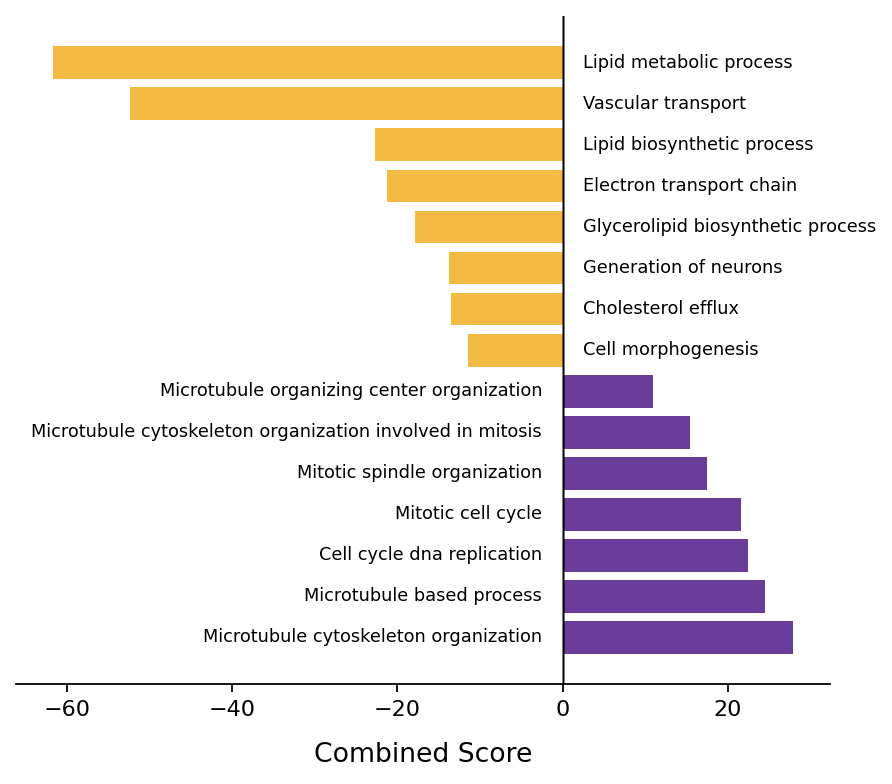

In [36]:
%run -i '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/helper_functions/GO_barplot.py'
# Plot
GO_barplot(FAM107A_RG_hsNcx_vs_mmDG_combined)
# Save the plot
#fig = plt.gcf()
plt.grid(False)
plt.tight_layout()
plt.savefig("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/GO/hs_ncx_rg2_vs_mm_dg_rg_1/Barplot_hs_ncx_rg2_vs_mm_dg_rg_1.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()